In [ ]:
import pandas as pd
# upload Training.csv and Test.csv from the kaggle competition!
Training_Data = pd.read_csv('Training.csv')
Testing_Data = pd.read_csv('Test.csv')
cutoff=4

In [ ]:
#All the required library importing
from sklearn import linear_model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
#Preprocessing data
def data_encoder(dataset):
  dataset['category'] = dataset.category.astype('category')
  dataset['vote'] = np.where(np.isfinite(dataset.vote),dataset.vote,-1)
  dataset['vote'] = dataset.vote.astype('int')
  return dataset

In [ ]:
#New dataframes with processed features
def create_dataframe(dataset, train = True):
    dataframe = pd.DataFrame(
    {'summary': dataset['summary'],
    'reviewText': dataset['reviewText'],
    'category': dataset['category'],
    'vote': dataset['vote']})

    if train == True :
      dataframe['overall'] = dataset['overall']
    dataframe = dataframe.replace(np.nan, '')
    return dataframe

In [ ]:
#Column transofrmer: to process the different features
from sklearn.compose import ColumnTransformer
#CountVectorizer:for text features
from sklearn.feature_extraction.text import CountVectorizer
#OneHotEncoder: for everything else
from sklearn.preprocessing import OneHotEncoder

column_trans = ColumnTransformer([
    ('summary_tf', CountVectorizer(),'summary'),
    ('review_tf', CountVectorizer(),'reviewText'),
    ('category_tf', OneHotEncoder(dtype='int',handle_unknown='ignore'),['category']),
    ('vote_tf', OneHotEncoder(dtype='int',handle_unknown='ignore'),['vote'])],remainder='passthrough', verbose_feature_names_out=True)

In [ ]:
#Model-1 (tuned hyper-parameters)
from sklearn.linear_model import LogisticRegression
LogRegCLF_1 = LogisticRegression(random_state=2, solver='liblinear', C=0.2, penalty='l2', max_iter=25)

In [ ]:
#Model-2 (tuned hyper-parameters)
from sklearn.tree import DecisionTreeClassifier
DecTreeCLF_2 = DecisionTreeClassifier(random_state=2, max_depth =5, splitter='best')

In [ ]:
#Model-3 (tuned hyper-parameters)
from sklearn.ensemble import RandomForestClassifier
RanForestCLF_3 = RandomForestClassifier(max_depth=None, max_features=0.3,  random_state=2)

In [ ]:
#Pipelines: to give preeprocessed data to Classifiers
from sklearn.pipeline import Pipeline

CLFPipeline_1 = Pipeline(steps=[
    ('column_trans', column_trans),
    ('model', LogRegCLF_1)
])

CLFPipeline_2 = Pipeline(steps=[
    ('column_trans', column_trans),
    ('model', DecTreeCLF_2)
])

CLFPipeline_3 = Pipeline(steps=[
    ('column_trans', column_trans),
    ('model', RanForestCLF_3)
])

In [ ]:
from sklearn.model_selection import train_test_split

TrainingDF = create_dataframe(data_encoder(Training_Data), train=True)
X = TrainingDF[['summary','reviewText','vote','category']]
y = np.where(TrainingDF['overall']>cutoff,1,0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [ ]:
#Printing values from each pipleine
print(CLFPipeline_1.get_params())
print(CLFPipeline_2.get_params())
print(CLFPipeline_3.get_params())

{'memory': None, 'steps': [('column_trans', ColumnTransformer(remainder='passthrough',
                  transformers=[('summary_tf', CountVectorizer(), 'summary'),
                                ('review_tf', CountVectorizer(), 'reviewText'),
                                ('category_tf',
                                 OneHotEncoder(dtype='int',
                                               handle_unknown='ignore'),
                                 ['category']),
                                ('vote_tf',
                                 OneHotEncoder(dtype='int',
                                               handle_unknown='ignore'),
                                 ['vote'])])), ('model', LogisticRegression(C=0.2, max_iter=25, random_state=2, solver='liblinear'))], 'verbose': False, 'column_trans': ColumnTransformer(remainder='passthrough',
                  transformers=[('summary_tf', CountVectorizer(), 'summary'),
                                ('review_tf', CountVectoriz

In [ ]:
#Grids for tuning (hyper-parameters)
GridParameters_1 = {'model__C' : [0.1,0.5,0.8,1.3,1.7],'model__max_iter': np.arange(25, 1000, 250, dtype=int)}
GridParameters_2 = {'model__splitter' : ['best', 'random'],'model__max_depth' : [None,2,5]}
GridParameters_3 = {'model__max_depth' : [None,2,5],'model__max_features' : ['sqrt', 0.3]}

In [ ]:
#Grid Search CV ---> hyper parameter tuning
from sklearn.model_selection import GridSearchCV

def perform_gridsearch_THP(pipeline, grid_params, model):
  GridSearch = GridSearchCV(pipeline, grid_params, scoring='accuracy', verbose=3)
  GridSearch.fit(X_train, y_train)

  print("Best Score: "+str(GridSearch.best_score_))
  print("Best Parameters: "+str(GridSearch.best_params_))
  print("Test Score: "+str(GridSearch.score(X_test,y_test)))

  return GridSearch

In [ ]:
GridSearch_1= perform_gridsearch_THP(CLFPipeline_1, GridParameters_1, 'Logistic Regression')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ..model__C=0.1, model__max_iter=25;, score=0.890 total time=   4.0s
[CV 2/5] END ..model__C=0.1, model__max_iter=25;, score=0.891 total time=   5.2s
[CV 3/5] END ..model__C=0.1, model__max_iter=25;, score=0.881 total time=   3.9s
[CV 4/5] END ..model__C=0.1, model__max_iter=25;, score=0.891 total time=   3.4s
[CV 5/5] END ..model__C=0.1, model__max_iter=25;, score=0.883 total time=   5.5s
[CV 1/5] END .model__C=0.1, model__max_iter=275;, score=0.890 total time=   3.4s
[CV 2/5] END .model__C=0.1, model__max_iter=275;, score=0.891 total time=   3.6s
[CV 3/5] END .model__C=0.1, model__max_iter=275;, score=0.881 total time=   5.6s
[CV 4/5] END .model__C=0.1, model__max_iter=275;, score=0.891 total time=   3.5s
[CV 5/5] END .model__C=0.1, model__max_iter=275;, score=0.883 total time=   3.3s
[CV 1/5] END .model__C=0.1, model__max_iter=525;, score=0.890 total time=   4.3s
[CV 2/5] END .model__C=0.1, model__max_iter=525

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END ..model__C=0.5, model__max_iter=25;, score=0.881 total time=   4.7s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END ..model__C=0.5, model__max_iter=25;, score=0.885 total time=   4.3s
[CV 5/5] END ..model__C=0.5, model__max_iter=25;, score=0.880 total time=   4.2s
[CV 1/5] END .model__C=0.5, model__max_iter=275;, score=0.888 total time=   6.0s
[CV 2/5] END .model__C=0.5, model__max_iter=275;, score=0.892 total time=   5.0s
[CV 3/5] END .model__C=0.5, model__max_iter=275;, score=0.881 total time=   5.0s
[CV 4/5] END .model__C=0.5, model__max_iter=275;, score=0.885 total time=   5.9s
[CV 5/5] END .model__C=0.5, model__max_iter=275;, score=0.880 total time=   4.2s
[CV 1/5] END .model__C=0.5, model__max_iter=525;, score=0.888 total time=   5.0s
[CV 2/5] END .model__C=0.5, model__max_iter=525;, score=0.892 total time=   4.3s
[CV 3/5] END .model__C=0.5, model__max_iter=525;, score=0.881 total time=   4.6s
[CV 4/5] END .model__C=0.5, model__max_iter=525;, score=0.885 total time=   6.8s
[CV 5/5] END .model__C=0.5, model__max_iter=525;, score=0.880 total time=   4.2s
[CV 1/5] END .model__C=0.5, 

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END ..model__C=0.8, model__max_iter=25;, score=0.892 total time=   4.5s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END ..model__C=0.8, model__max_iter=25;, score=0.880 total time=   3.6s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END ..model__C=0.8, model__max_iter=25;, score=0.886 total time=   3.9s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END ..model__C=0.8, model__max_iter=25;, score=0.881 total time=   5.3s
[CV 1/5] END .model__C=0.8, model__max_iter=275;, score=0.884 total time=   4.6s
[CV 2/5] END .model__C=0.8, model__max_iter=275;, score=0.891 total time=   5.7s
[CV 3/5] END .model__C=0.8, model__max_iter=275;, score=0.878 total time=   4.9s
[CV 4/5] END .model__C=0.8, model__max_iter=275;, score=0.884 total time=   4.6s
[CV 5/5] END .model__C=0.8, model__max_iter=275;, score=0.881 total time=   5.3s
[CV 1/5] END .model__C=0.8, model__max_iter=525;, score=0.884 total time=   4.1s
[CV 2/5] END .model__C=0.8, model__max_iter=525;, score=0.891 total time=   5.9s
[CV 3/5] END .model__C=0.8, model__max_iter=525;, score=0.878 total time=   4.9s
[CV 4/5] END .model__C=0.8, model__max_iter=525;, score=0.884 total time=   4.8s
[CV 5/5] END .model__C=0.8, model__max_iter=525;, score=0.881 total time=   6.4s
[CV 1/5] END .model__C=0.8, model__max_iter=775;, score=0.884 total time=   4.0s
[CV 2/5] END .model__C=0.8, 

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END ..model__C=1.3, model__max_iter=25;, score=0.890 total time=   5.1s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END ..model__C=1.3, model__max_iter=25;, score=0.876 total time=   4.3s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END ..model__C=1.3, model__max_iter=25;, score=0.882 total time=   4.2s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END ..model__C=1.3, model__max_iter=25;, score=0.880 total time=   5.6s
[CV 1/5] END .model__C=1.3, model__max_iter=275;, score=0.883 total time=   4.0s
[CV 2/5] END .model__C=1.3, model__max_iter=275;, score=0.889 total time=   4.2s
[CV 3/5] END .model__C=1.3, model__max_iter=275;, score=0.875 total time=   6.3s
[CV 4/5] END .model__C=1.3, model__max_iter=275;, score=0.882 total time=   4.5s
[CV 5/5] END .model__C=1.3, model__max_iter=275;, score=0.880 total time=   5.2s
[CV 1/5] END .model__C=1.3, model__max_iter=525;, score=0.883 total time=   4.8s
[CV 2/5] END .model__C=1.3, model__max_iter=525;, score=0.889 total time=   5.0s
[CV 3/5] END .model__C=1.3, model__max_iter=525;, score=0.875 total time=   6.1s
[CV 4/5] END .model__C=1.3, model__max_iter=525;, score=0.882 total time=   4.1s
[CV 5/5] END .model__C=1.3, model__max_iter=525;, score=0.880 total time=   4.6s
[CV 1/5] END .model__C=1.3, model__max_iter=775;, score=0.883 total time=   5.8s
[CV 2/5] END .model__C=1.3, 

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END ..model__C=1.7, model__max_iter=25;, score=0.883 total time=   4.9s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END ..model__C=1.7, model__max_iter=25;, score=0.888 total time=   4.4s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END ..model__C=1.7, model__max_iter=25;, score=0.876 total time=   5.2s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END ..model__C=1.7, model__max_iter=25;, score=0.881 total time=   4.3s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END ..model__C=1.7, model__max_iter=25;, score=0.881 total time=   3.7s
[CV 1/5] END .model__C=1.7, model__max_iter=275;, score=0.884 total time=   6.7s
[CV 2/5] END .model__C=1.7, model__max_iter=275;, score=0.888 total time=   5.6s
[CV 3/5] END .model__C=1.7, model__max_iter=275;, score=0.874 total time=   6.6s
[CV 4/5] END .model__C=1.7, model__max_iter=275;, score=0.882 total time=   5.5s
[CV 5/5] END .model__C=1.7, model__max_iter=275;, score=0.879 total time=   6.6s
[CV 1/5] END .model__C=1.7, model__max_iter=525;, score=0.884 total time=   5.1s
[CV 2/5] END .model__C=1.7, model__max_iter=525;, score=0.888 total time=   6.2s
[CV 3/5] END .model__C=1.7, model__max_iter=525;, score=0.874 total time=   7.4s
[CV 4/5] END .model__C=1.7, model__max_iter=525;, score=0.882 total time=   6.0s
[CV 5/5] END .model__C=1.7, model__max_iter=525;, score=0.879 total time=   6.6s
[CV 1/5] END .model__C=1.7, model__max_iter=775;, score=0.884 total time=   5.3s
[CV 2/5] END .model__C=1.7, 

In [ ]:
GridSearch_2= perform_gridsearch_THP(CLFPipeline_2, GridParameters_2, 'Decision Tree Classifier')

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END model__max_depth=None, model__splitter=best;, score=0.850 total time=  15.2s
[CV 2/5] END model__max_depth=None, model__splitter=best;, score=0.854 total time=  16.0s
[CV 3/5] END model__max_depth=None, model__splitter=best;, score=0.836 total time=  15.6s
[CV 4/5] END model__max_depth=None, model__splitter=best;, score=0.841 total time=  15.5s
[CV 5/5] END model__max_depth=None, model__splitter=best;, score=0.836 total time=  15.8s
[CV 1/5] END model__max_depth=None, model__splitter=random;, score=0.853 total time=  13.6s
[CV 2/5] END model__max_depth=None, model__splitter=random;, score=0.852 total time=  12.5s
[CV 3/5] END model__max_depth=None, model__splitter=random;, score=0.840 total time=  14.2s
[CV 4/5] END model__max_depth=None, model__splitter=random;, score=0.850 total time=  12.5s
[CV 5/5] END model__max_depth=None, model__splitter=random;, score=0.850 total time=  12.4s
[CV 1/5] END model__max_depth=

In [ ]:
GridSearch_3= perform_gridsearch_THP(CLFPipeline_3, GridParameters_3, 'Decision Tree Classifier')

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END model__max_depth=None, model__max_features=sqrt;, score=0.870 total time=  53.3s
[CV 2/5] END model__max_depth=None, model__max_features=sqrt;, score=0.870 total time=  52.0s
[CV 3/5] END model__max_depth=None, model__max_features=sqrt;, score=0.865 total time=  49.5s
[CV 4/5] END model__max_depth=None, model__max_features=sqrt;, score=0.866 total time=  52.8s
[CV 5/5] END model__max_depth=None, model__max_features=sqrt;, score=0.864 total time=  52.8s
[CV 1/5] END model__max_depth=None, model__max_features=0.3;, score=0.887 total time= 5.4min
[CV 2/5] END model__max_depth=None, model__max_features=0.3;, score=0.885 total time= 5.5min
[CV 3/5] END model__max_depth=None, model__max_features=0.3;, score=0.874 total time= 5.3min
[CV 4/5] END model__max_depth=None, model__max_features=0.3;, score=0.882 total time= 5.4min
[CV 5/5] END model__max_depth=None, model__max_features=0.3;, score=0.876 total time= 5.4min
[CV 1

In [ ]:
#Model fitting-1
CLFPipeline_1.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('column_trans',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('summary_tf',
                                                  CountVectorizer(),
                                                  'summary'),
                                                 ('review_tf',
                                                  CountVectorizer(),
                                                  'reviewText'),
                                                 ('category_tf',
                                                  OneHotEncoder(dtype='int',
                                                                handle_unknown='ignore'),
                                                  ['category']),
                                                 ('vote_tf',
                                                  OneHotEncoder(dtype='int',
                                                                handle_unknown='ignore'),
                                                  ['vote'])])),
                ('model',
                 LogisticRegression(C=0.2, max_iter=25, random_state=2,
                                    solver='liblinear'))])

In [ ]:
#Model fitting-2
CLFPipeline_2.fit(X_train, y_train)

Pipeline(steps=[('column_trans',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('summary_tf',
                                                  CountVectorizer(),
                                                  'summary'),
                                                 ('review_tf',
                                                  CountVectorizer(),
                                                  'reviewText'),
                                                 ('category_tf',
                                                  OneHotEncoder(dtype='int',
                                                                handle_unknown='ignore'),
                                                  ['category']),
                                                 ('vote_tf',
                                                  OneHotEncoder(dtype='int',
                                                                handle_unknown='ignore'),
                                                  ['vote'])])),
                ('model', DecisionTreeClassifier(max_depth=5, random_state=2))])

In [ ]:
#Model fitting-3
CLFPipeline_3.fit(X_train, y_train)

Pipeline(steps=[('column_trans',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('summary_tf',
                                                  CountVectorizer(),
                                                  'summary'),
                                                 ('review_tf',
                                                  CountVectorizer(),
                                                  'reviewText'),
                                                 ('category_tf',
                                                  OneHotEncoder(dtype='int',
                                                                handle_unknown='ignore'),
                                                  ['category']),
                                                 ('vote_tf',
                                                  OneHotEncoder(dtype='int',
                                                                handle_unknown='ignore'),
                                                  ['vote'])])),
                ('model',
                 RandomForestClassifier(max_features=0.3, random_state=2))])

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
from IPython.display import display, HTML
#With the given predicted y--->calculating false_positives, false_negatives, true_positives and true_negatives
def performance_analysis(y_actual,y_pred):
    false_positive = np.sum((y_actual == 0) & (y_pred == 1))
    false_negative = np.sum((y_actual == 1) & (y_pred == 0))
    true_positive = np.sum((y_actual == 1) & (y_pred == 1))
    true_negative = np.sum((y_actual == 0) & (y_pred == 0))
    
    return false_positive, false_negative, true_positive, true_negative


#Calculation of metrics for each model
def metrics_value(model, y_test, y_pred, y_prob, model_pipeline):
  F1_Score = f1_score(y_test, y_pred, average = 'macro')
  false_positive, false_negative, true_positive, true_negative = performance_analysis(y_test,y_pred)
  Accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
  y_prob = y_prob[:,1]
  fpr, tpr, Thresholds = roc_curve(y_test, y_prob)
  AUC_Score = roc_auc_score(y_test, y_prob)

  # Define HTML tags for bold text
  BOLD = '<b>'
  RESET = '</b>'

  # Printing the values in bold
  display(HTML(f"{BOLD}Model : {model}{RESET}"))
  display(HTML(f"{BOLD}F1 Score:{RESET} {F1_Score}"))
  display(HTML(f"{BOLD}AUC Score:{RESET} {AUC_Score}"))
  display(HTML(f"{BOLD}Accuracy:{RESET} {Accuracy}"))
  display(HTML(f"{BOLD}Thresholds:{RESET} {Thresholds}"))
  

  #Plotting the values
  plt.plot(fpr, tpr, color='yellowgreen', label=f'ROC curve for model: {model}')
  plt.plot([0, 1], [0, 1])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.legend()
  plt.show() 
  print('\n')

  #Confusion Matrix
  disp = ConfusionMatrixDisplay.from_estimator(
          model_pipeline,
          X_test,
          y_test,
          display_labels=[0,1],
          cmap=plt.cm.Greens
      )
  plt.title("Confusion Matrix")
  plt.show()

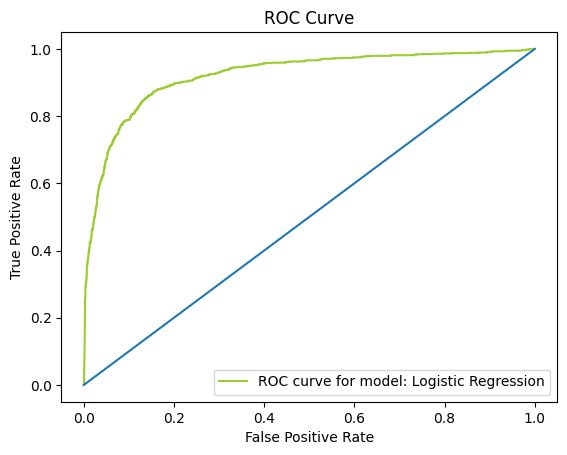

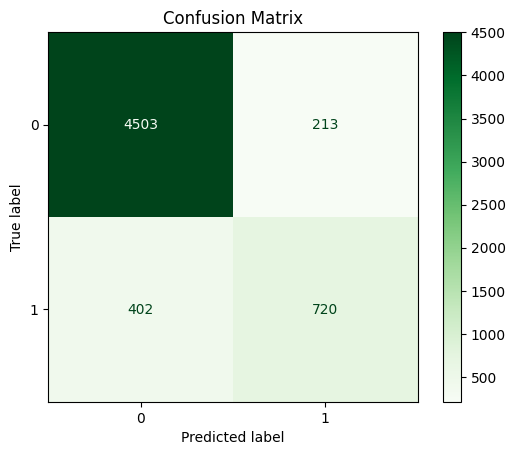

In [ ]:
#Predicting the overall score from the test data
y_PredictionModel_1 = CLFPipeline_1.predict(X_test)
y_ProbModel_1 = CLFPipeline_1.predict_proba(X_test)
metrics_value("Logistic Regression", y_test,y_PredictionModel_1,y_ProbModel_1, CLFPipeline_1)

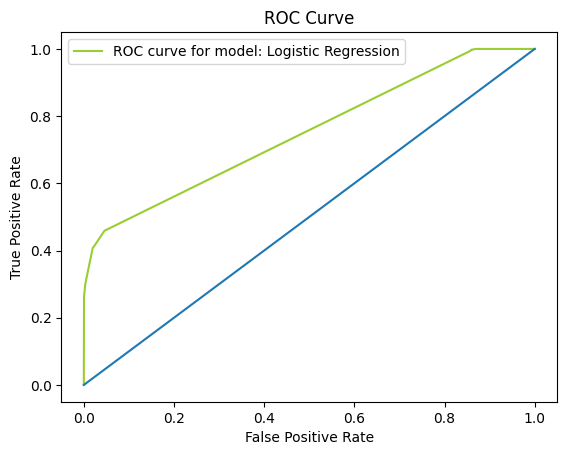

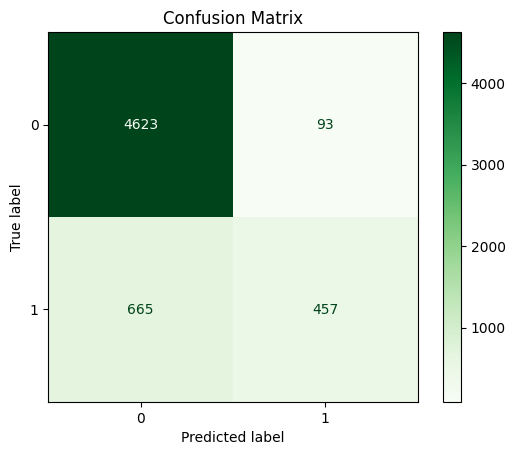

In [ ]:
#Predicting the overall score from the test data
y_PredictionModel_2 = CLFPipeline_2.predict(X_test)
y_ProbModel_2 = CLFPipeline_2.predict_proba(X_test)
metrics_value("Logistic Regression", y_test,y_PredictionModel_2,y_ProbModel_2, CLFPipeline_2)

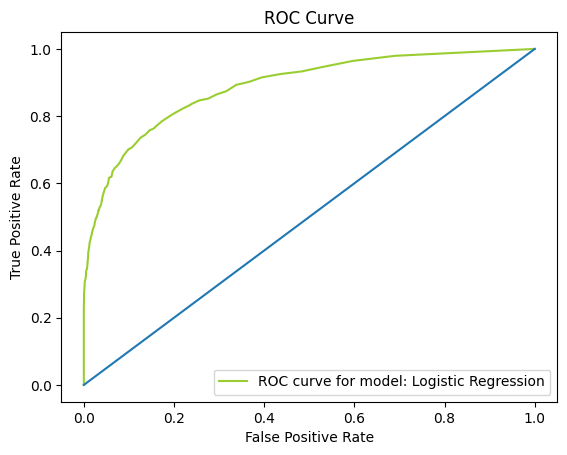

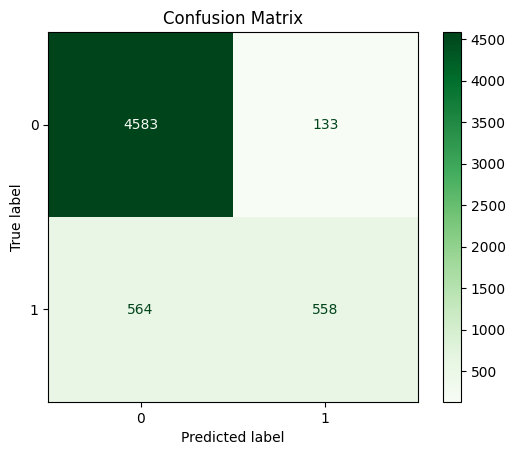

In [ ]:
#Predicting the overall score from the test data
y_PredictionModel_3 = CLFPipeline_3.predict(X_test)
y_ProbModel_3 = CLFPipeline_3.predict_proba(X_test)
metrics_value("Logistic Regression", y_test,y_PredictionModel_3,y_ProbModel_3, CLFPipeline_3)

In [ ]:
#Cleaning the test data
Test_DataFrame = create_dataframe(data_encoder(Testing_Data), train=False)
Test_DataFrame = Test_DataFrame.replace(np.nan, '')

#Predictions for test data
test_predictions = CLFPipeline_1.predict(Test_DataFrame)

In [ ]:
# IMPORTANT: use 'id' and 'predicted' as the column names
test_ids = list(Test_DataFrame.index) # the 'id' column name is the index of the test samples

In [ ]:
test_submission = pd.DataFrame({'id':test_ids, 'binary_split_4':test_predictions})
print(test_submission.shape) # should be (4500, 2)
test_submission.head()

(4500, 2)


,id,binary_split_4
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [ ]:
test_submission.to_csv('test_submission_part4_final.csv', index=False)